In [1]:
import sys
import os
import matplotlib.pyplot as plt 


sys.path.append(os.path.abspath('../src'))

In [2]:
from networks import run_single_network, create_random_network
from utils import plot_raster, plot_adjacency_matrix


In [3]:
neurons, G = create_random_network(N=500, p_connect=0.07, weight_bounds=(0.1,5))

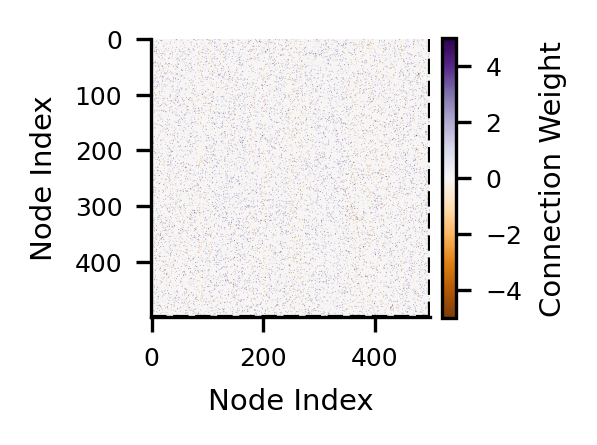

In [10]:
plot_adjacency_matrix(G, figsize=(2,2))
plt.show()

In [15]:
T_seconds = 1

In [16]:
T =int( T_seconds* 2000)
V_hist, S_hist, I_syn_hist, I_ext, final_state, final_stdp_state = run_single_network(
    neurons, G, network_type='stdp_syn', T=T, nkey=32)


In [17]:
I_syn_hist.mean()/(I_syn_hist.mean()+10)

Array(0.05425413, dtype=float32)

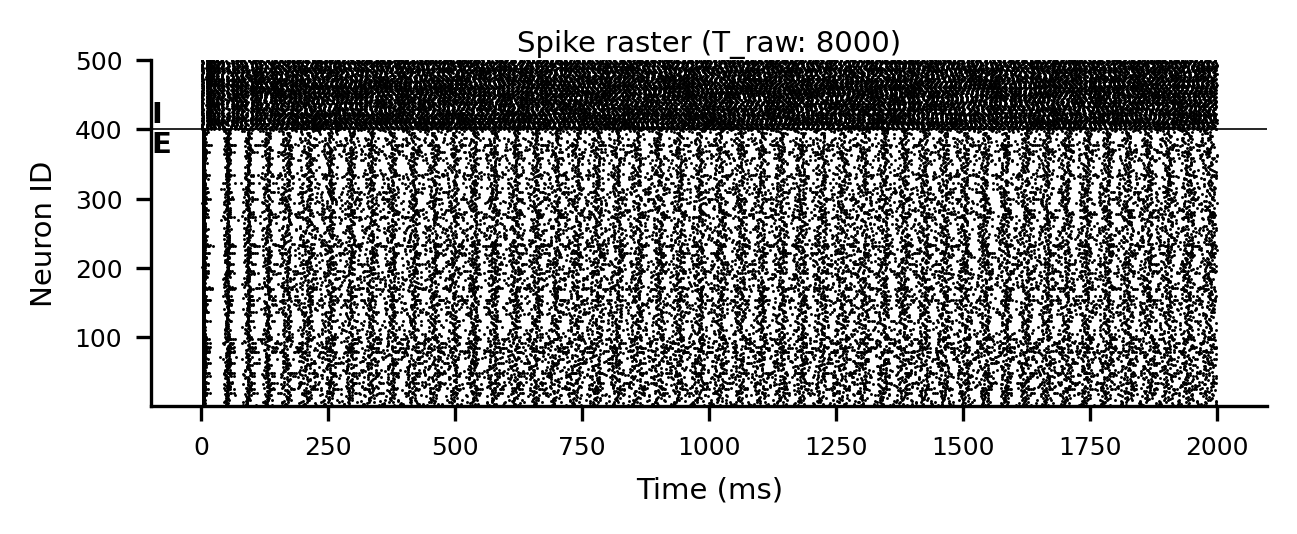

In [18]:
plot_raster(S_hist, neurons, final_state.W, T_total=T, title=f'Spike raster (T_raw: {int(T/0.25)})')
plt.show()

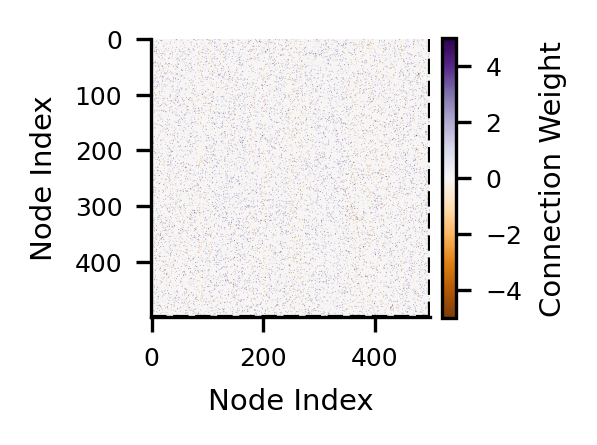

In [26]:
import infomeasure as im
import antropy as ant
import numpy as np 
from tqdm import tqdm 

In [27]:
im_args = {"approach": "miller_madow", "base": 2}


In [113]:
A = np.array(S_hist)
A.shape

(16000, 500)

In [110]:
im.entropy(A, **im_args)

np.float64(13.93387556530953)

In [30]:
int(T/0.25)/500

32.0

100%|██████████| 8/8 [00:00<00:00, 33.62it/s]


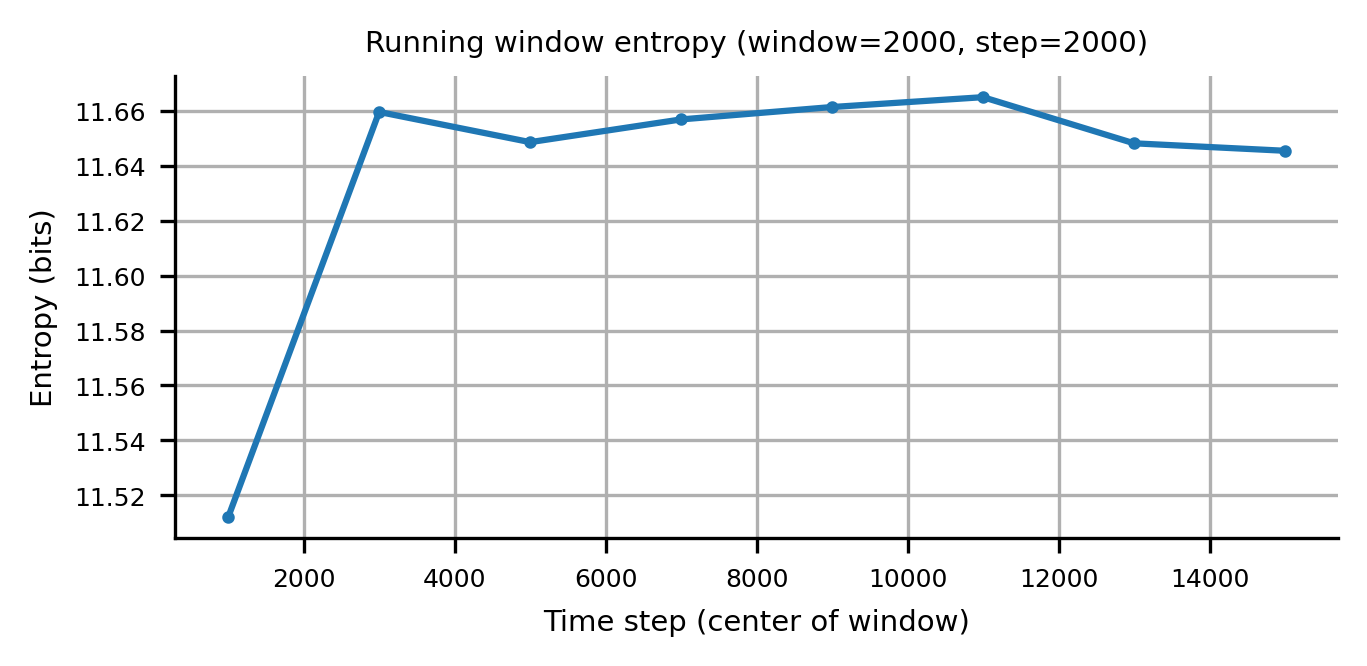

In [ ]:
# Running window entropy

window_size = int(500/0.25)
step_size = window_size

entropies = []
times = []

im_args = {"approach": "miller_madow", "base": 2}

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A[start:start+window_size]
    H = im.entropy(window, **im_args)
    entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [117]:
A

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]],
      shape=(16000, 500))

In [116]:
A[:,0].flatten().astype(np.int32)

array([0, 0, 0, ..., 0, 0, 0], shape=(16000,), dtype=int32)

In [114]:
im_args = {"approach": "miller_madow", "base": 2}
# Single Sequence Entropy: Calculates the entropy of the spike train for a single neuron (e.g., neuron 0) over time.
# Measures the unpredictability or randomness of that neuron's firing pattern (how often it spikes vs. is silent).
# High entropy means the neuron fires in a more random pattern; low entropy means it fires in a more regular or predictable way.
H = im.entropy(A[:,0].flatten().astype(np.int32), **im_args)
print('single sequence', H)


# Joint Entropy of the Full Matrix: 
# Treats each row (all neurons at a single time step) as a single "symbol" and computes the entropy across time.
# Measures the unpredictability of the entire network's state at each time step. High entropy means 
# many possible network states; low entropy means the network is often in the same or similar states.
H = im.entropy(A, **im_args)
print('joint entropy', H)

# Joint Entropy Across Neurons (List of Sequences)
# Treats each neuron's spike train as a separate sequence and computes the joint entropy across all neurons.
# Measures the combined unpredictability of all neurons' firing patterns together. High joint entropy means
# that knowing some neurons' activity doesn't help much in predicting others; low joint entropy means
# that neurons' activities are correlated or dependent.
H = im.entropy(
    [A[:,i].flatten().astype(np.int32) for i in range(A.shape[1])]
    , **im_args)
print('joint entropy', H)

# Joint Entropy Across Time (List of Time Slices) -> Confirmation that both methods give same result as Full matrix above.
H = im.entropy(
    [A[i,:].flatten().astype(np.int32) for i in range(A.shape[0])]
    , **im_args)
print('joint entropy', H)

single sequence 0.1759184659271818
joint entropy 14.574087872039348
joint entropy 9.68568911006568
joint entropy 14.574087872039348


In [115]:
im_args = {"approach": "bayes", "alpha": 0.5, "base": 2}
# Single Sequence Entropy: Calculates the entropy of the spike train for a single neuron (e.g., neuron 0) over time.
# Measures the unpredictability or randomness of that neuron's firing pattern (how often it spikes vs. is silent).
# High entropy means the neuron fires in a more random pattern; low entropy means it fires in a more regular or predictable way.
H = im.entropy(A[:,0].flatten().astype(np.int32), **im_args)
print('single sequence', H)


# Joint Entropy of the Full Matrix: 
# Treats each row (all neurons at a single time step) as a single "symbol" and computes the entropy across time.
# Measures the unpredictability of the entire network's state at each time step. High entropy means 
# many possible network states; low entropy means the network is often in the same or similar states.
H = im.entropy(A, **im_args)
print('joint entropy', H)

# Joint Entropy Across Neurons (List of Sequences)
# Treats each neuron's spike train as a separate sequence and computes the joint entropy across all neurons.
# Measures the combined unpredictability of all neurons' firing patterns together. High joint entropy means
# that knowing some neurons' activity doesn't help much in predicting others; low joint entropy means
# that neurons' activities are correlated or dependent.
H = im.entropy(
    [A[:,i].flatten().astype(np.int32) for i in range(A.shape[1])]
    , **im_args)
print('joint entropy', H)

H = im.entropy(
    A.T
    , **im_args)
print('joint entropy', H)

# Joint Entropy Across Time (List of Time Slices) -> Confirmation that both methods give same result as Full matrix above.
H = im.entropy(
    [A[i,:].flatten().astype(np.int32) for i in range(A.shape[0])]
    , **im_args)
print('joint entropy', H)

single sequence 0.1760274568552296
joint entropy 13.895561779481243
joint entropy 8.965784284662087
joint entropy 8.965784284662087
joint entropy 13.895561779481243


In [19]:
im_args = {"approach": "sbn", "alpha": 0.5, "base": 2}
# Single Sequence Entropy: Calculates the entropy of the spike train for a single neuron (e.g., neuron 0) over time.
# Measures the unpredictability or randomness of that neuron's firing pattern (how often it spikes vs. is silent).
# High entropy means the neuron fires in a more random pattern; low entropy means it fires in a more regular or predictable way.
H = im.entropy(A[:,0].flatten().astype(np.int32), **im_args)
print('single sequence', H)


# Joint Entropy of the Full Matrix: 
# Treats each row (all neurons at a single time step) as a single "symbol" and computes the entropy across time.
# Measures the unpredictability of the entire network's state at each time step. High entropy means 
# many possible network states; low entropy means the network is often in the same or similar states.
H = im.entropy(A, **im_args)
print('joint entropy', H)

# Joint Entropy Across Neurons (List of Sequences)
# Treats each neuron's spike train as a separate sequence and computes the joint entropy across all neurons.
# Measures the combined unpredictability of all neurons' firing patterns together. High joint entropy means
# that knowing some neurons' activity doesn't help much in predicting others; low joint entropy means
# that neurons' activities are correlated or dependent.
H = im.entropy(
    [A[:,i].flatten().astype(np.int32) for i in range(A.shape[1])]
    , **im_args)
print('joint entropy', H)

H = im.entropy(
    A.T
    , **im_args)
print('joint entropy', H)

# Joint Entropy Across Time (List of Time Slices) -> Confirmation that both methods give same result as Full matrix above.
H = im.entropy(
    [A[i,:].flatten().astype(np.int32) for i in range(A.shape[0])]
    , **im_args)
print('joint entropy', H)

NameError: name 'A' is not defined

In [ ]:
# The maximum possible entropy for your spike train matrix A (shape (Time, Neurons)) 
# is achieved when all possible microstates (all possible binary patterns of neuron activity) 
# are equally likely

# For a network of N neurons, the number of possible microstates per time step is ( 2^N ).
# The maximum entropy per time step is ( N ) bits.
# For a sequence of T time steps, the entropy is still measured per time step (since each row is a microstate).

# Calculate the maximum possible entropy for the network state (per time step)
N = A.shape[1]  # number of neurons
max_entropy = N  # in bits, since log2(2^N) = N
print(f"Maximum possible entropy per time step: {max_entropy} bits")

T = A.shape[0]  # number of time steps
max_total_entropy = T * N  # in bits
print(f"Maximum possible total entropy for {T} time steps: {max_total_entropy} bits")

Maximum possible entropy per time step: 500 bits
Maximum possible total entropy for 16000 time steps: 8000000 bits


In [99]:
im_args = {"approach": "ansb", "base": 2}
H = im.entropy(A[:,0].flatten().astype(np.int32), **im_args)
print('single sequence', H)

H = im.entropy(A, **im_args)
print('joint entropy', H)

2025-09-20 12:48:33,323 |  WARNING | ansb.py:93 | Data is not sufficiently undersampled (N/K = 8000.000 > 0.1), so calculation may diverge...
2025-09-20 12:48:33,736 |  WARNING | ansb.py:93 | Data is not sufficiently undersampled (N/K = 1.009 > 0.1), so calculation may diverge...


single sequence 13.798755900417065
joint entropy 20.579436564246055


2025-09-20 12:48:27,522 |  WARNING | ansb.py:93 | Data is not sufficiently undersampled (N/K = 1.009 > 0.1), so calculation may diverge...


joint entropy 20.579436564246055


In [ ]:
im_args = {"approach": "bayes", "alpha": 0.5, "base": 2}
# Single Sequence Entropy: Calculates the entropy of the spike train for a single neuron (e.g., neuron 0) over time.
# Measures the unpredictability or randomness of that neuron's firing pattern (how often it spikes vs. is silent).
# High entropy means the neuron fires in a more random pattern; low entropy means it fires in a more regular or predictable way.
H = im.entropy(A[:,0].flatten().astype(np.int32), **im_args)
print('single sequence', H)


# Joint Entropy of the Full Matrix: 
# Treats each row (all neurons at a single time step) as a single "symbol" and computes the entropy across time.
# Measures the unpredictability of the entire network's state at each time step. High entropy means 
# many possible network states; low entropy means the network is often in the same or similar states.
H = im.entropy(A, **im_args)
print('joint entropy', H)

# Joint Entropy Across Neurons (List of Sequences)
# Treats each neuron's spike train as a separate sequence and computes the joint entropy across all neurons.
# Measures the combined unpredictability of all neurons' firing patterns together. High joint entropy means
# that knowing some neurons' activity doesn't help much in predicting others; low joint entropy means
# that neurons' activities are correlated or dependent.
H = im.entropy(
    [A[:,i].flatten().astype(np.int32) for i in range(A.shape[1])]
    , **im_args)
print('joint entropy', H)

# Joint Entropy Across Time (List of Time Slices) -> Confirmation that both methods give same result as Full matrix above.
H = im.entropy(
    [A[i,:].flatten().astype(np.int32) for i in range(A.shape[0])]
    , **im_args)
print('joint entropy', H)

array([0, 1], dtype=int32)

In [78]:

# Example with small, potentially correlated data
data = np.zeros(150).astype(np.int32)
data[34]=1
entropy_nsb = im.entropy(data, approach="nsb")
print(f"NSB Entropy: {entropy_nsb:.4f}")

# NSB can also calculate other measures with discrete data
data_x = [0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
data_y = [1, 1, 0, 1, 0, 1, 1, 0, 0, 1]
entropy_nsb = im.entropy((data_x,data_y), approach="nsb")
print(f"NSB Joint Entropy: {entropy_nsb:.4f}")
mi_nsb = im.mutual_information(data_x, data_y, approach="nsb")
print(f"NSB Mutual Information: {mi_nsb:.4f}")
te_nsb = im.transfer_entropy(data_x, data_y, approach="nsb")
print(f"NSB TE: {te_nsb:.4f}")

NSB Entropy: nan
NSB Joint Entropy: 1.2682
NSB Mutual Information: 0.0023
NSB TE: 0.1004


In [59]:
im_args = {"approach": "nsb", "base": 2}
H = im.entropy(A[:,0].flatten().astype(np.int32)[:10], **im_args)
H

np.float64(nan)

100%|██████████| 4/4 [00:00<00:00, 14.54it/s]


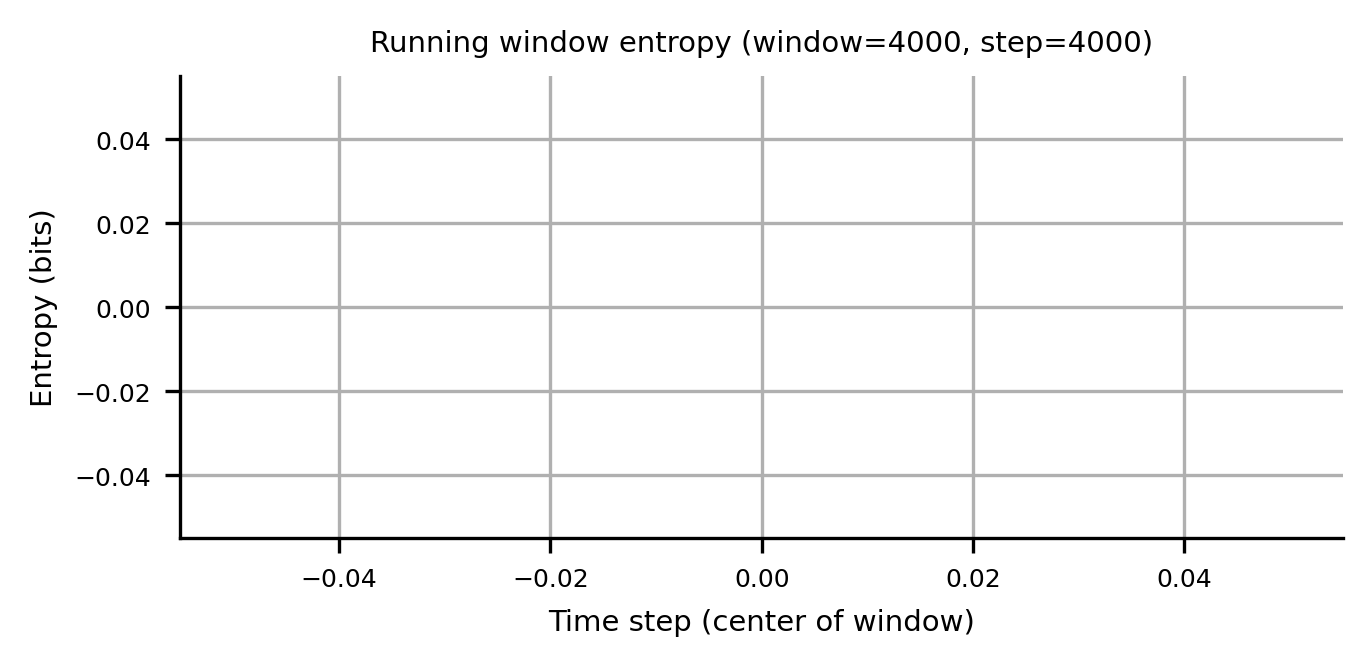

In [34]:
# Running window entropy

window_size = int(1000/0.25)
step_size = window_size

entropies = []
times = []

im_args = {"approach": "nsb", "base": 2}

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A[start:start+window_size]
    H = im.entropy(window, **im_args)
    entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

Window 50:   0%|          | 0/1581 [00:00<?, ?it/s]

Window 500: 100%|██████████| 1401/1401 [00:38<00:00, 36.68it/s]


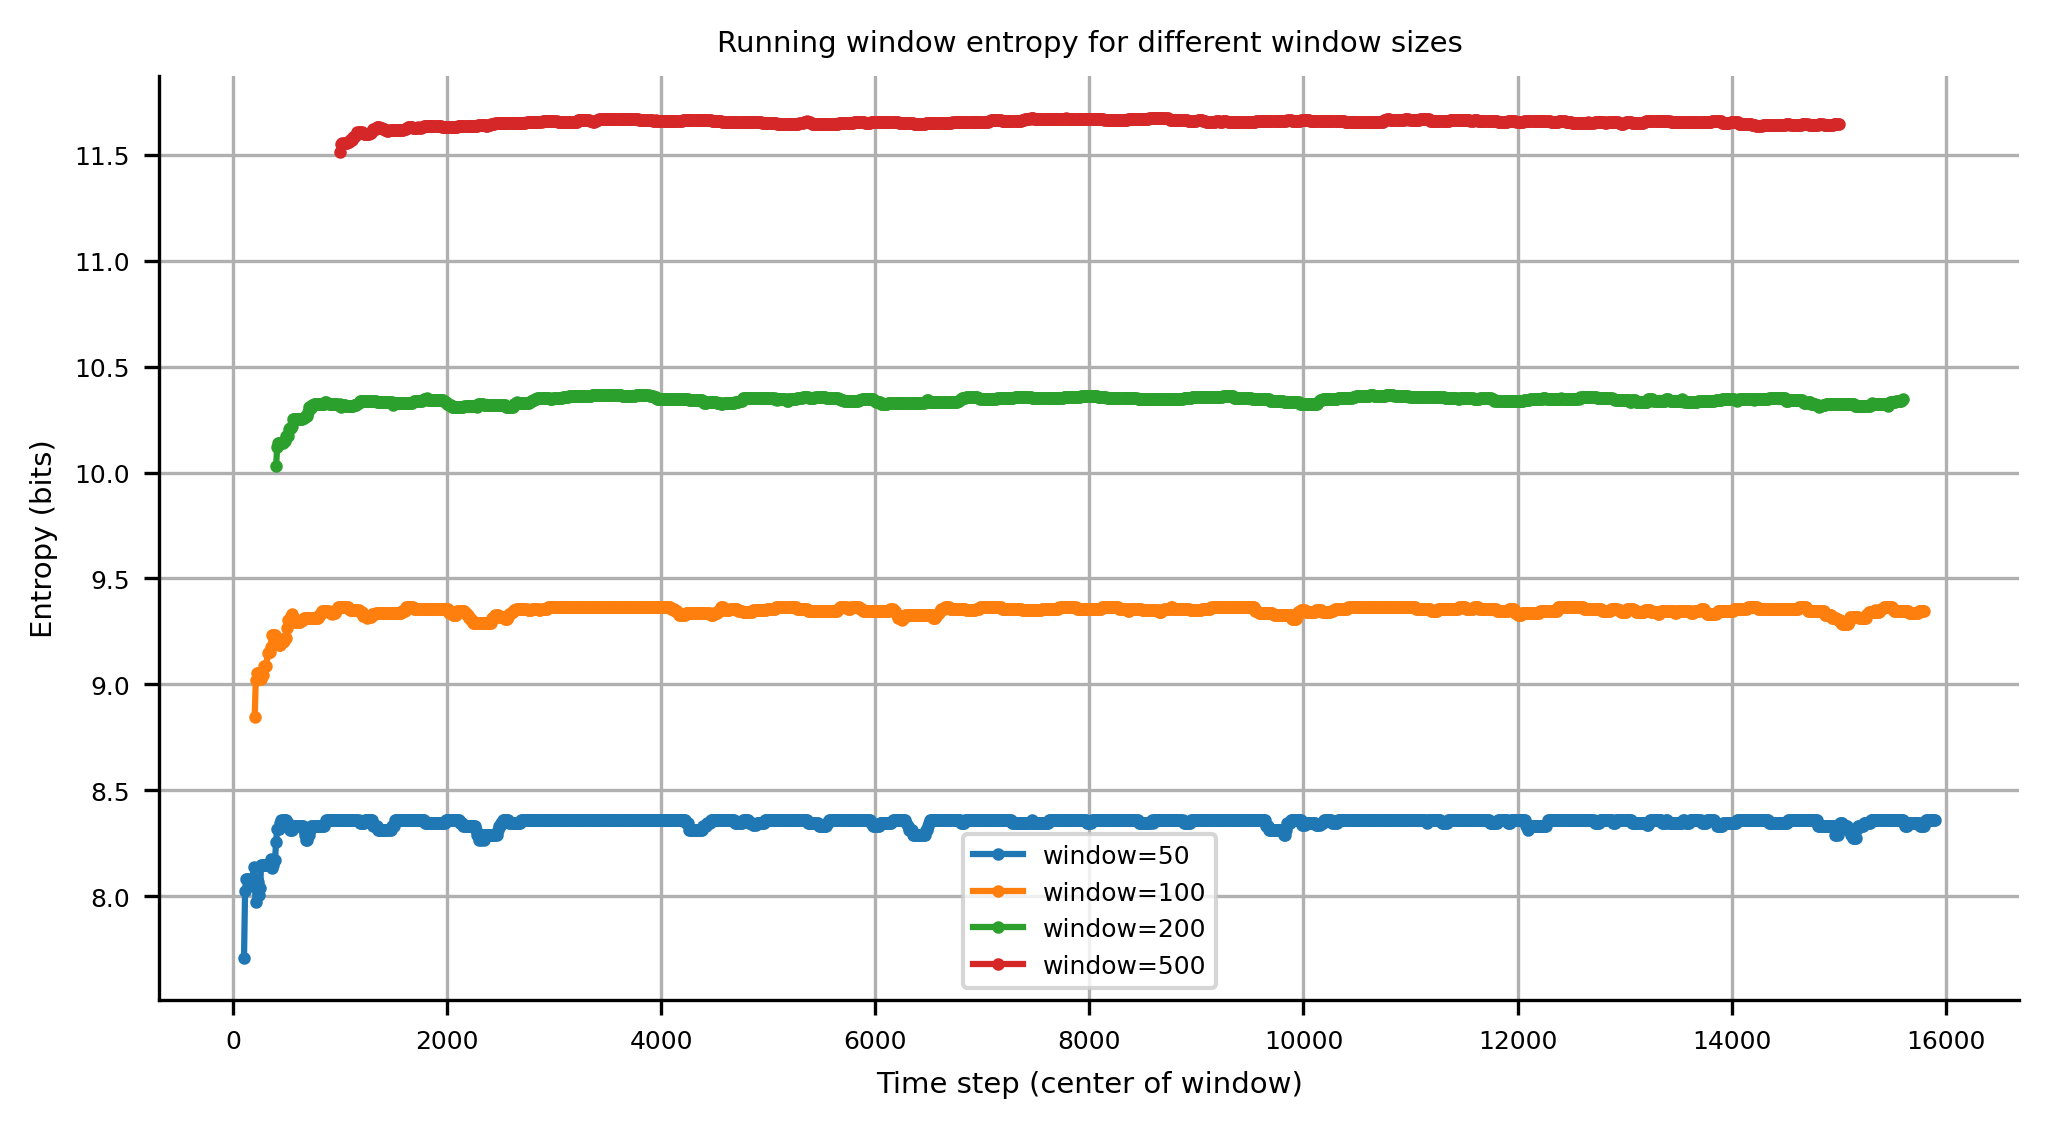

In [32]:
# Scan for different window sizes
window_sizes = [50, 100, 200, 500]
step_sizes = [int(w/0.25) for w in window_sizes]
results = {}

im_args = {"approach": "miller_madow", "base": 2}

for w, step in zip(window_sizes, step_sizes):
    window_size = int(w/0.25)
    step_size = 10 #window_size
    entropies = []
    times = []
    for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size), desc=f'Window {w}'):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)
        times.append(start + window_size//2)
    results[w] = (times, entropies)

# Plot all
plt.figure(figsize=(8,4))
for w in window_sizes:
    times, entropies = results[w]
    plt.plot(times, entropies, marker='o', markersize=2, label=f'window={w}')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title("Running window entropy for different window sizes")
plt.grid(True)
plt.legend()
plt.show()

Window 1000: 100%|██████████| 4/4 [00:00<00:00, 13.06it/s]


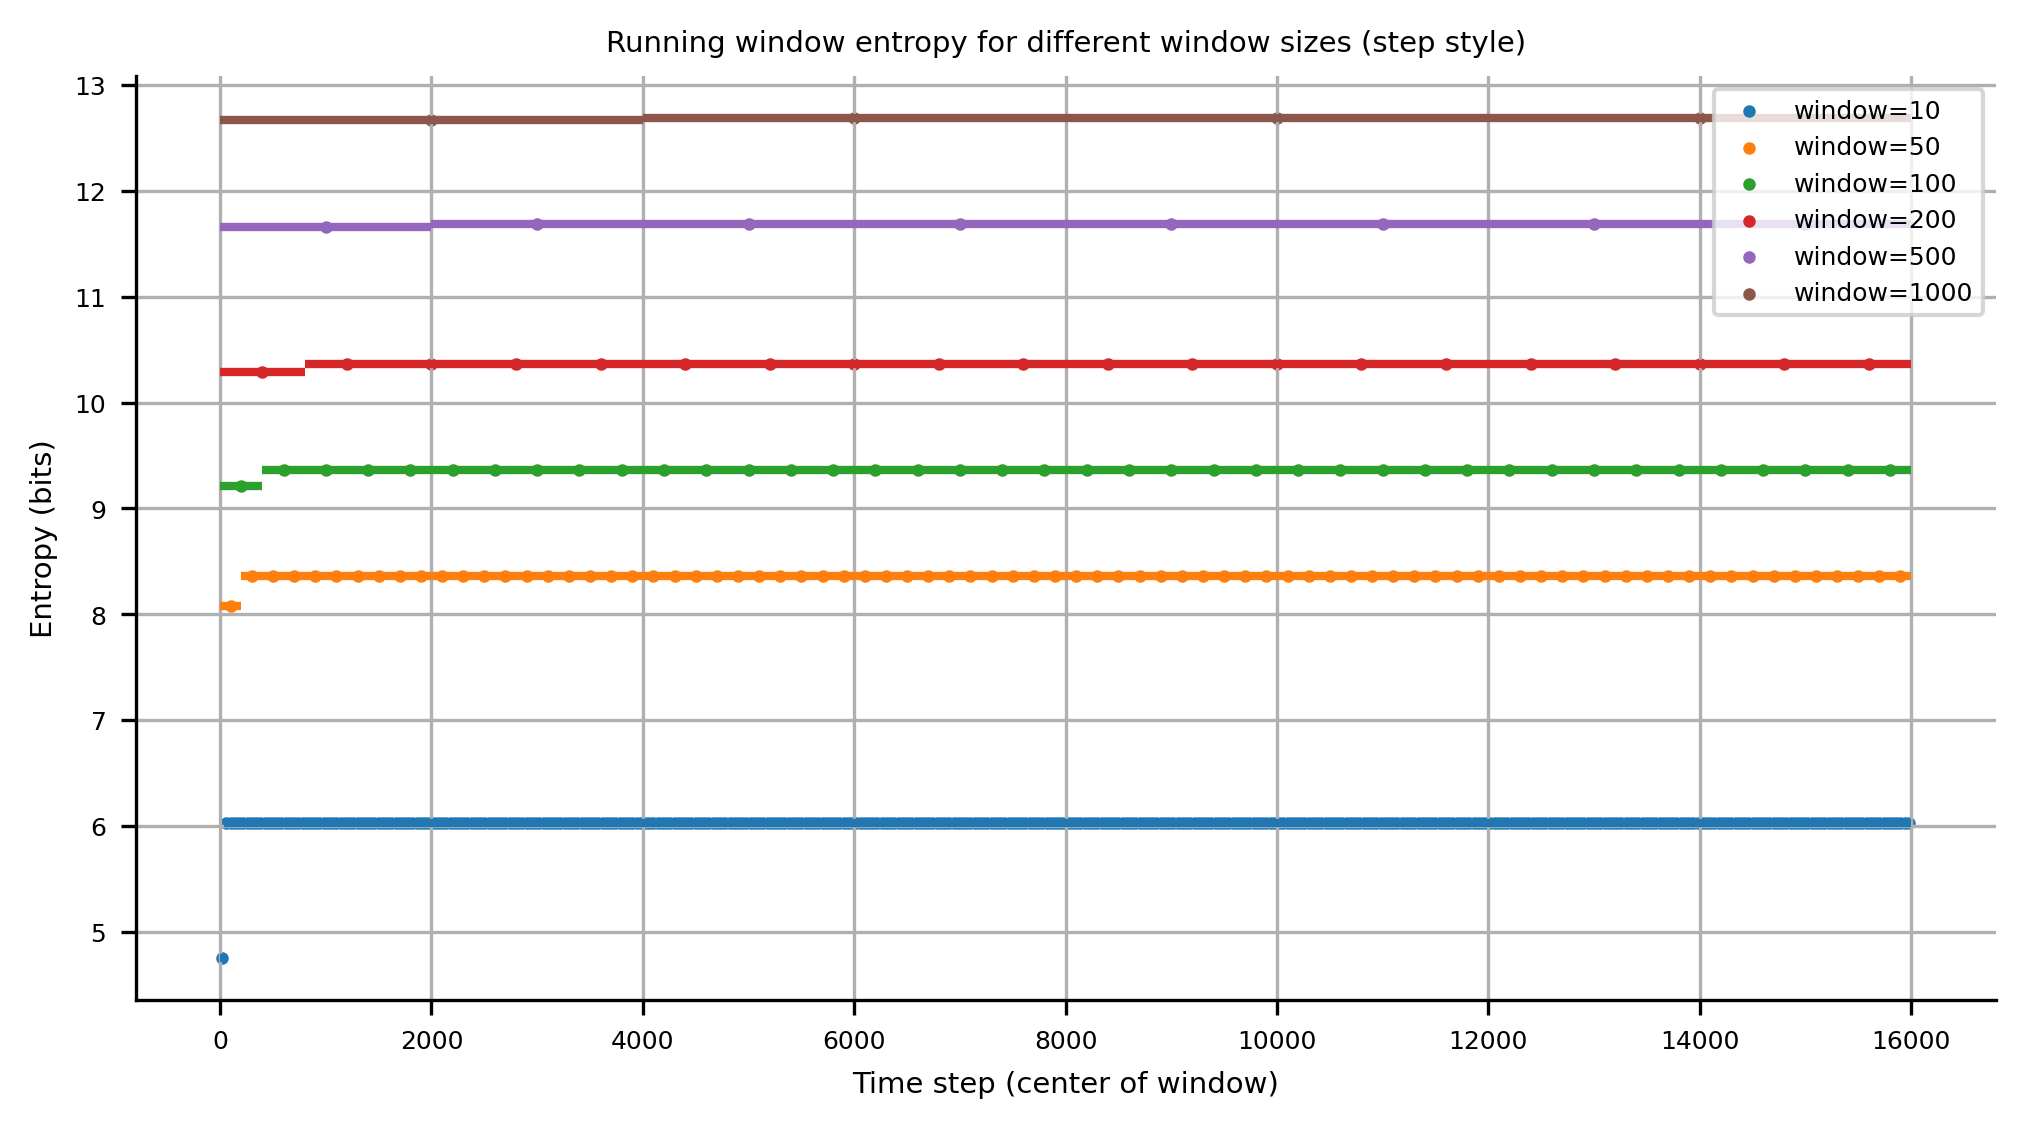

In [258]:
# Scan for different window sizes
window_sizes = [10, 50, 100, 200, 500, 1000]
step_sizes = [int(w/0.25) for w in window_sizes]
results = {}

for w, step in zip(window_sizes, step_sizes):
    window_size = int(w/0.25)
    step_size =  window_size
    entropies = []
    times = []
    for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size), desc=f'Window {w}'):
        window = A[start:start+window_size]
        H = im.entropy(window, **im_args)
        entropies.append(H)
        times.append(start + window_size//2)
    results[w] = (times, entropies)

# Plot all as step-like horizontal lines with markers, color per window size
plt.figure(figsize=(8,4))
for idx, (w, step) in enumerate(zip(window_sizes, step_sizes)):
    times, entropies = results[w]
    color = f'C{idx}'
    for t, H in zip(times, entropies):
        left = t - (step/2)
        right = t + (step/2)
        plt.hlines(H, left, right, colors=color, linewidth=2)
    plt.scatter(times, entropies, c=color, s=4, label=f'window={w}')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title("Running window entropy for different window sizes (step style)")
plt.grid(True)
plt.legend()
plt.show()

In [226]:
def add_noise_in_window(A, a, b, p=0.01, seed=None):
    """
    Add noise to binary spike matrix A within timesteps [a, b).
    
    """
    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    
    mask = rng.random(size=A_noisy[a:b].shape) < p
    A_noisy[a:b][mask] = 1 - A_noisy[a:b][mask]
    
    return A_noisy

In [227]:
array_test = A
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

/var/folders/g8/nl718mjj3q32_ynwvrcqd2wh0000gn/T/ipykernel_18333/529999541.py:5: RuntimeWarning: invalid value encountered in scalar divide
  R_H =  num_H / den_H


np.float64(nan)

In [228]:
A_noisy = add_noise_in_window(A, 8000, 12000)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


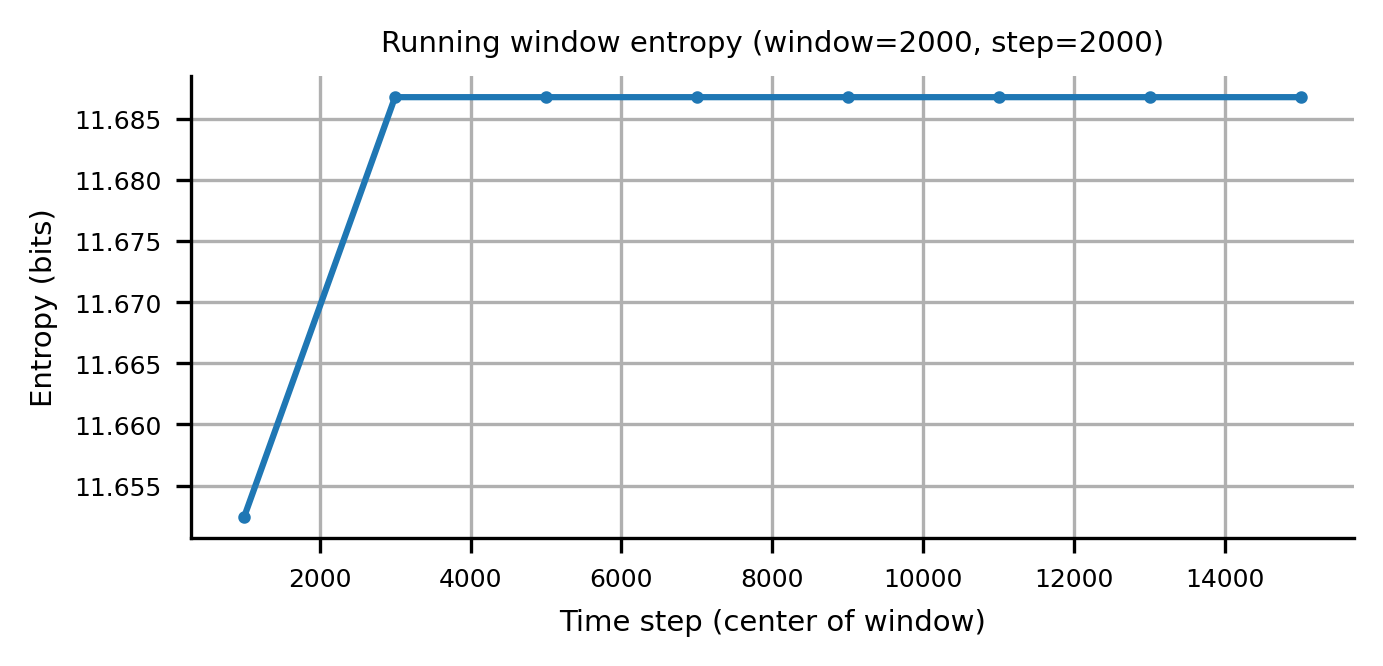

In [229]:
# Running window entropy
window_size = int(500/0.25)
step_size = window_size

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)

# Plot
plt.figure(figsize=(5,2))
plt.plot(times, n_entropies, marker='o', markersize=2)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

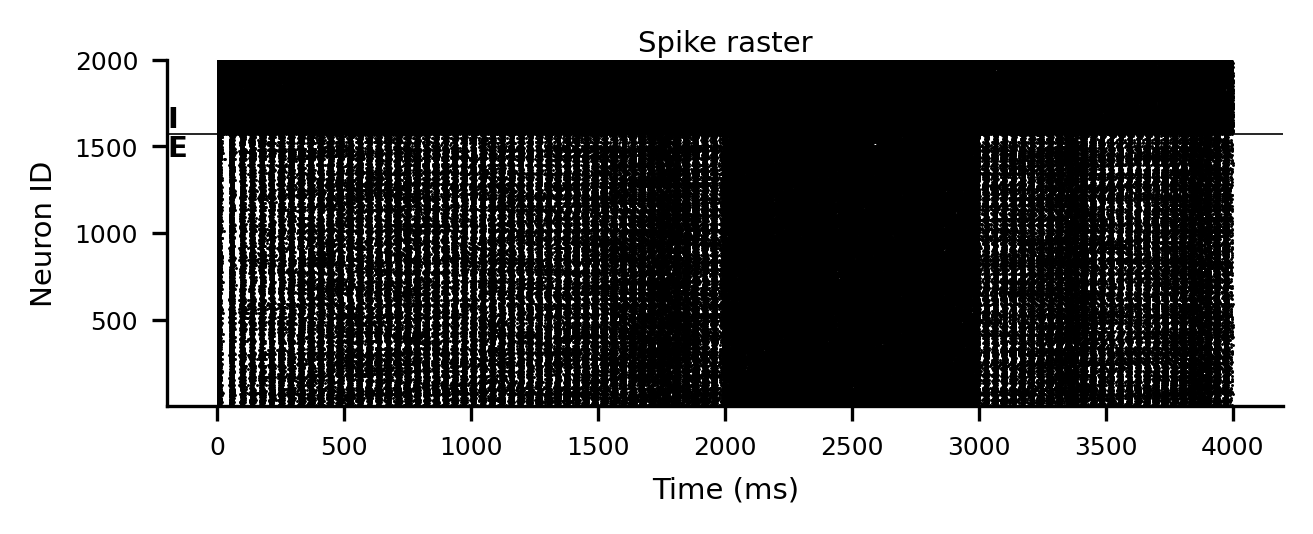

In [230]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

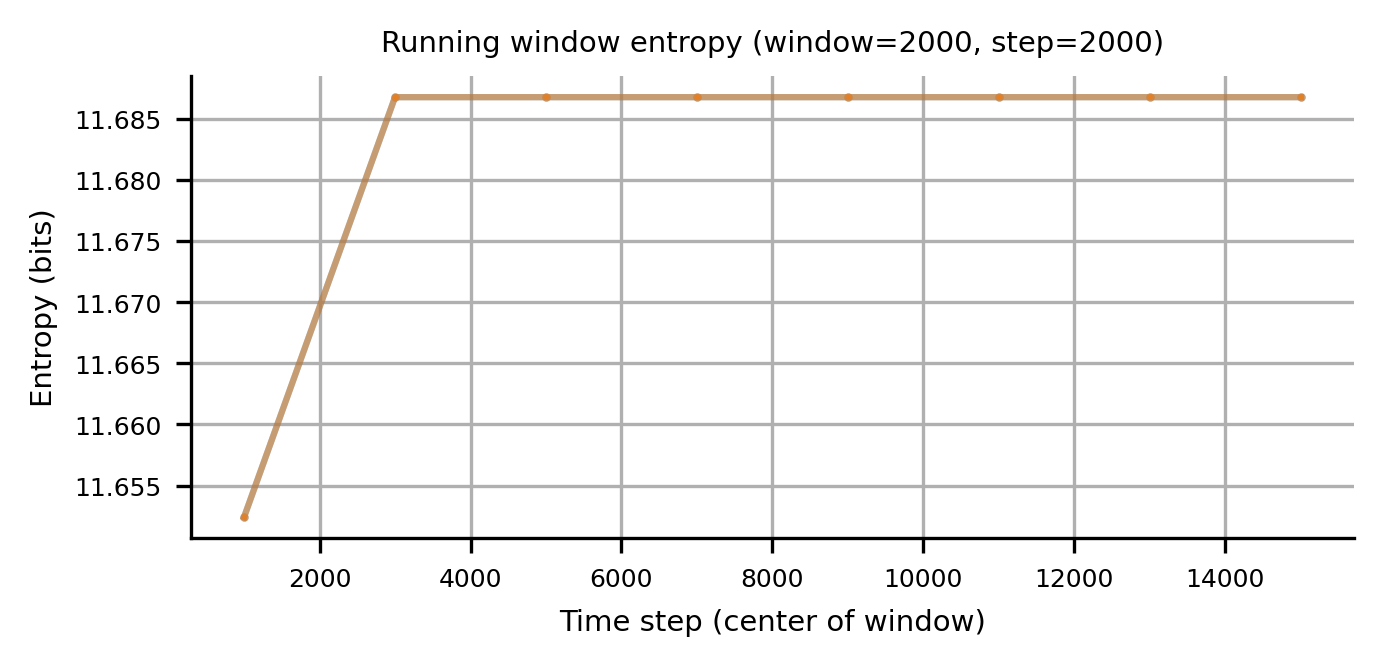

In [233]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1, alpha=0.5)
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5)
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.show()

In [54]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(1.1730112734075921)

In [17]:
def add_structured_noise(A, a, b, mode="silence", p=0.2, seed=None):

    rng = np.random.default_rng(seed)
    A_noisy = A.copy()
    segment = A_noisy[a:b]

    if mode == "silence":
        mask = (segment == 1) & (rng.random(segment.shape) < p)
        segment[mask] = 0
    elif mode == "burst":
        mask = (segment == 0) & (rng.random(segment.shape) < p)
        segment[mask] = 1
    else:
        raise ValueError("mode must be 'silence' or 'burst'")

    A_noisy[a:b] = segment
    return A_noisy



In [238]:
A_silenced = add_structured_noise(A, 8000, 12000,p=0.5)

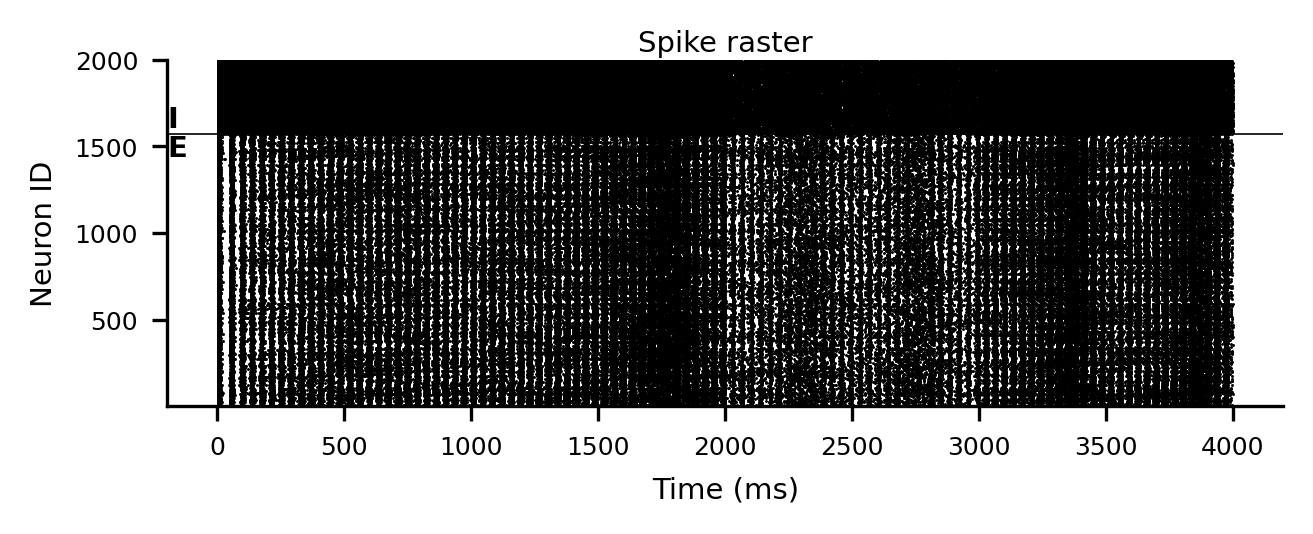

In [239]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [243]:
# Running window entropy
window_size = int(500/0.25)
step_size = window_size

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 8/8 [00:00<00:00, 17.20it/s]


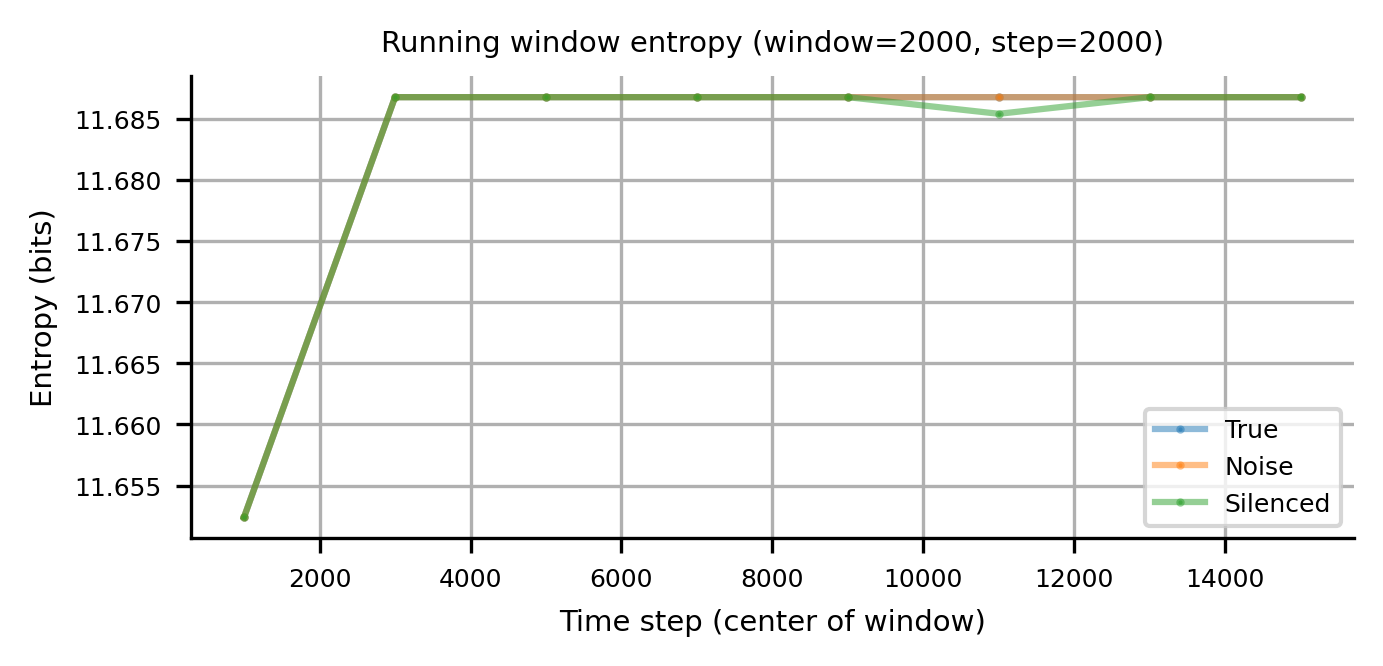

In [244]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

In [56]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(0.6275556156720316)

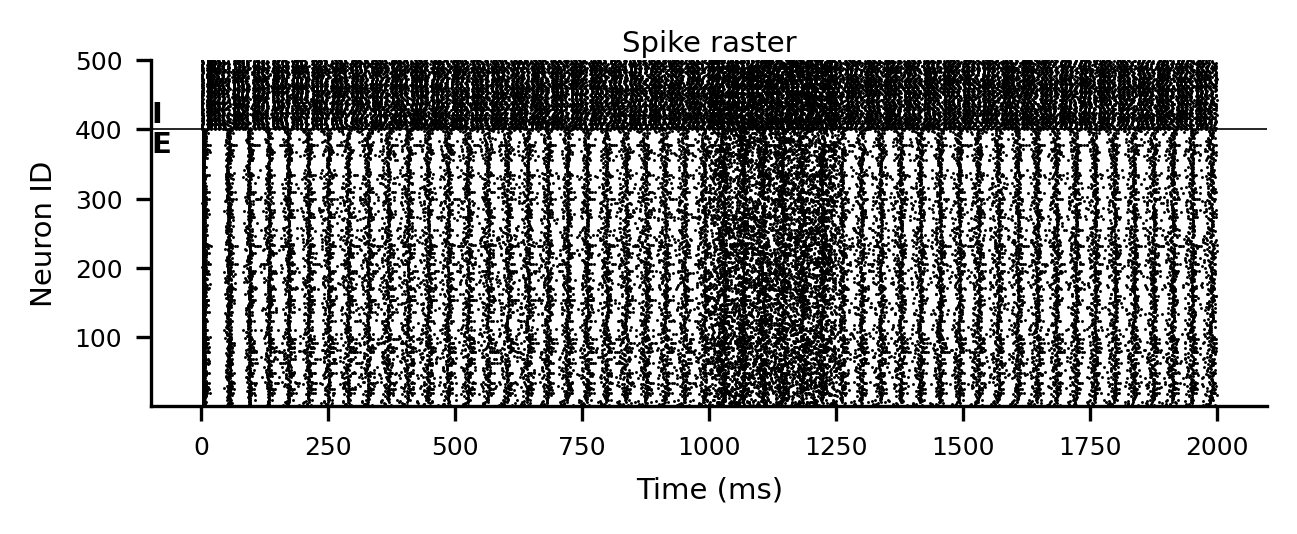

In [23]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [78]:
import jax

In [81]:
jax.devices("cpu")[0]

CpuDevice(id=0)

In [57]:
# Silence for ever
A_silenced = add_structured_noise(A, 4000, 8000)

In [25]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

s_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_silenced[start:start+window_size]
    H = im.entropy(window, **im_args)
    s_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:19<00:00, 31.41it/s]


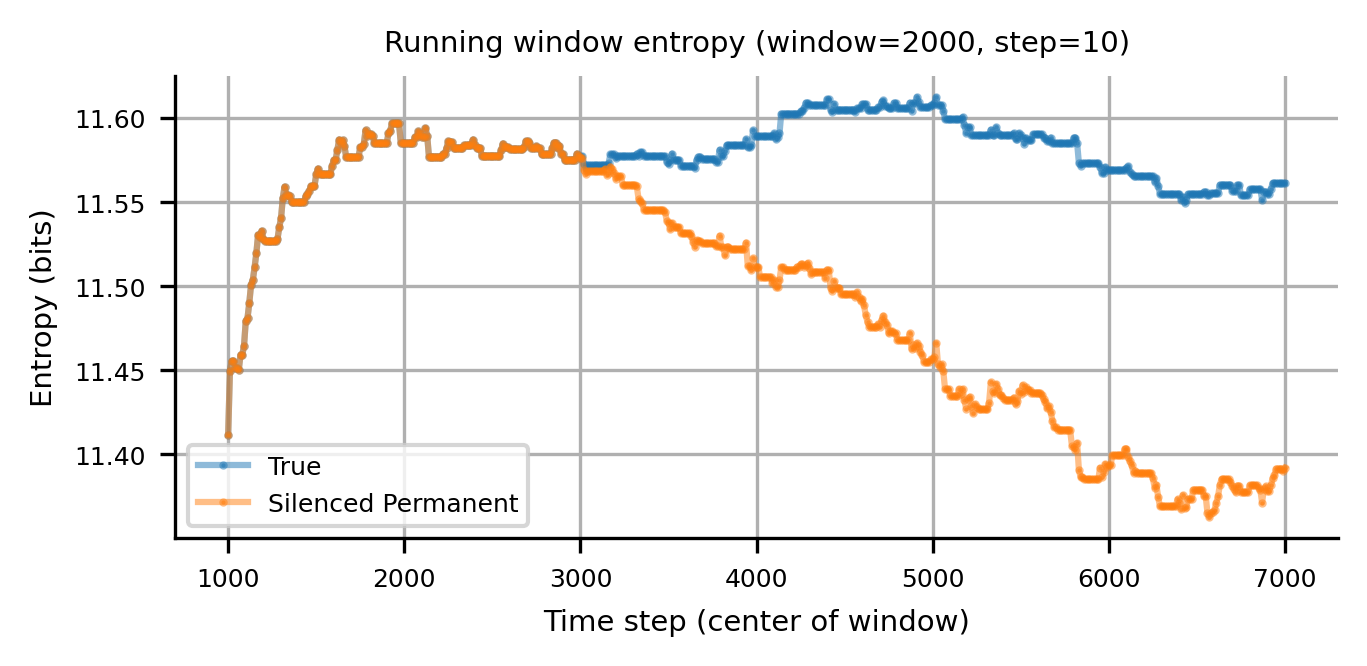

In [28]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
#plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()

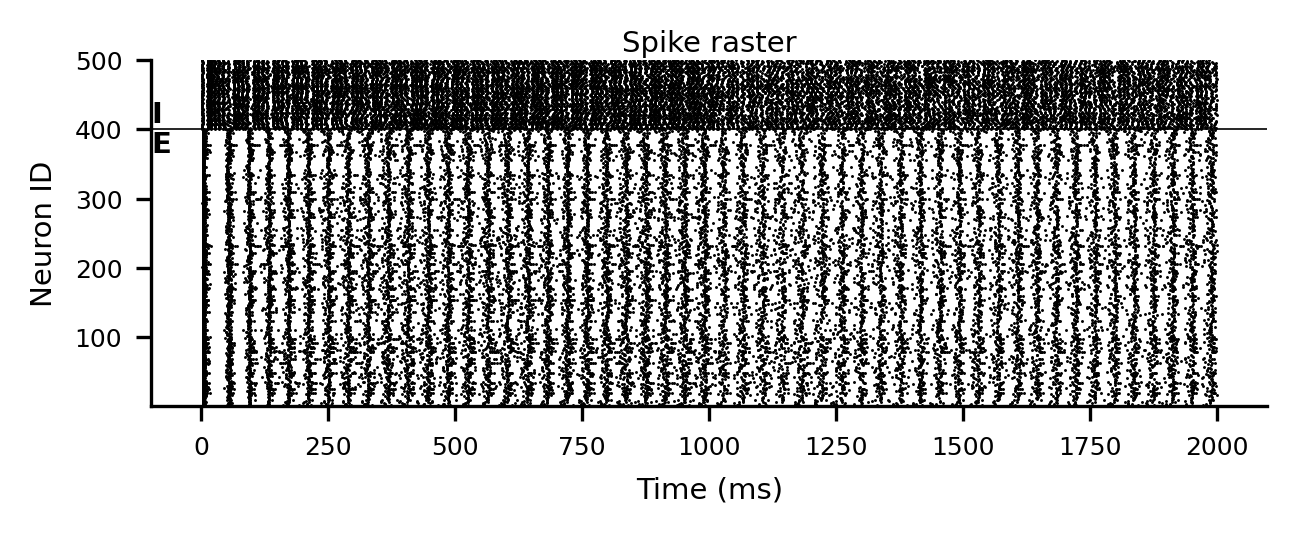

In [29]:
plot_raster(A_silenced, neurons, final_state.W, T_total=T)
plt.show()

In [58]:
array_test = A_silenced
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.2959106596908949)

In [59]:
# Permantent noise
A_noisy = add_noise_in_window(A, 4000, 8000)

In [31]:
# Running window entropy
window_size = int(500/0.25)
step_size = 10

n_entropies = []
times = []

for start in tqdm(range(0, A.shape[0] - window_size + 1, step_size)):
    window = A_noisy[start:start+window_size]
    H = im.entropy(window, **im_args)
    n_entropies.append(H)
    times.append(start + window_size//2)



100%|██████████| 601/601 [00:14<00:00, 42.14it/s]


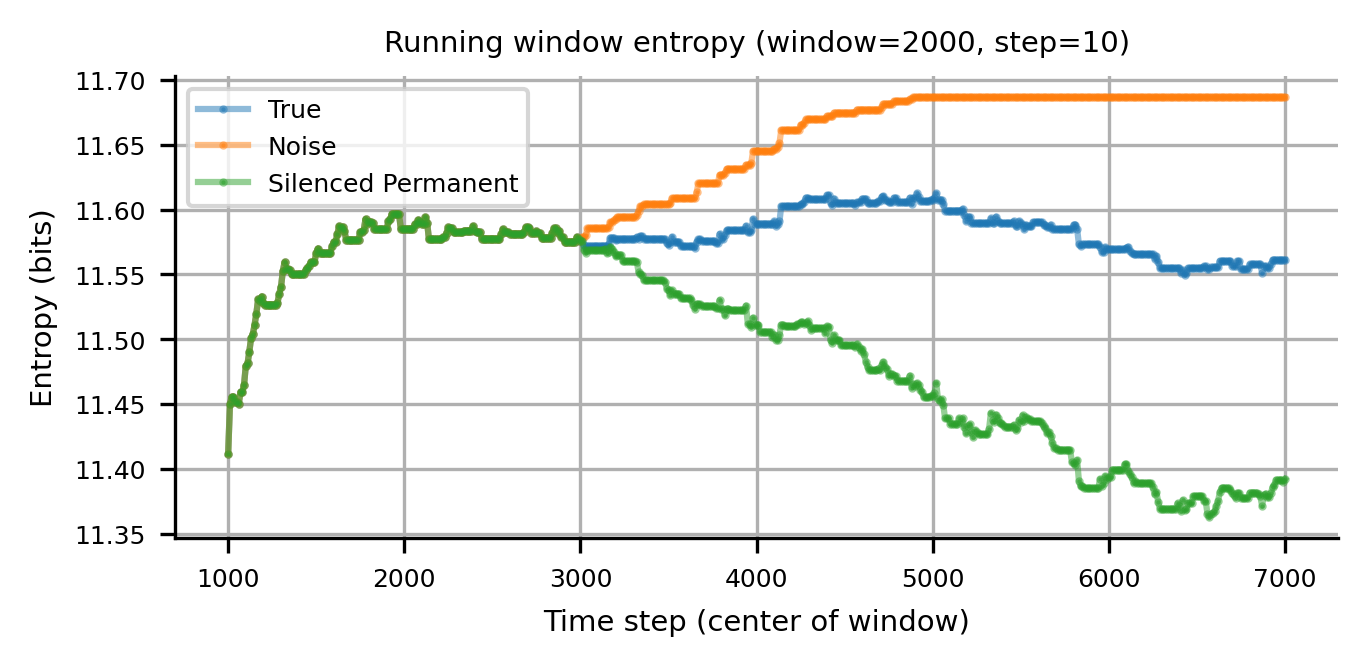

In [32]:
# Plot
plt.figure(figsize=(5,2))
plt.plot(times, entropies, marker='o', markersize=1,  alpha=0.5, label='True')
plt.plot(times, n_entropies, marker='o', markersize=1, alpha=0.5, label='Noise')
plt.plot(times, s_entropies, marker='o', markersize=1, alpha=0.5, label='Silenced Permanent')
plt.xlabel("Time step (center of window)")
plt.ylabel("Entropy (bits)")
plt.title(f"Running window entropy (window={window_size}, step={step_size})")
plt.grid(True)
plt.legend()
plt.show()#

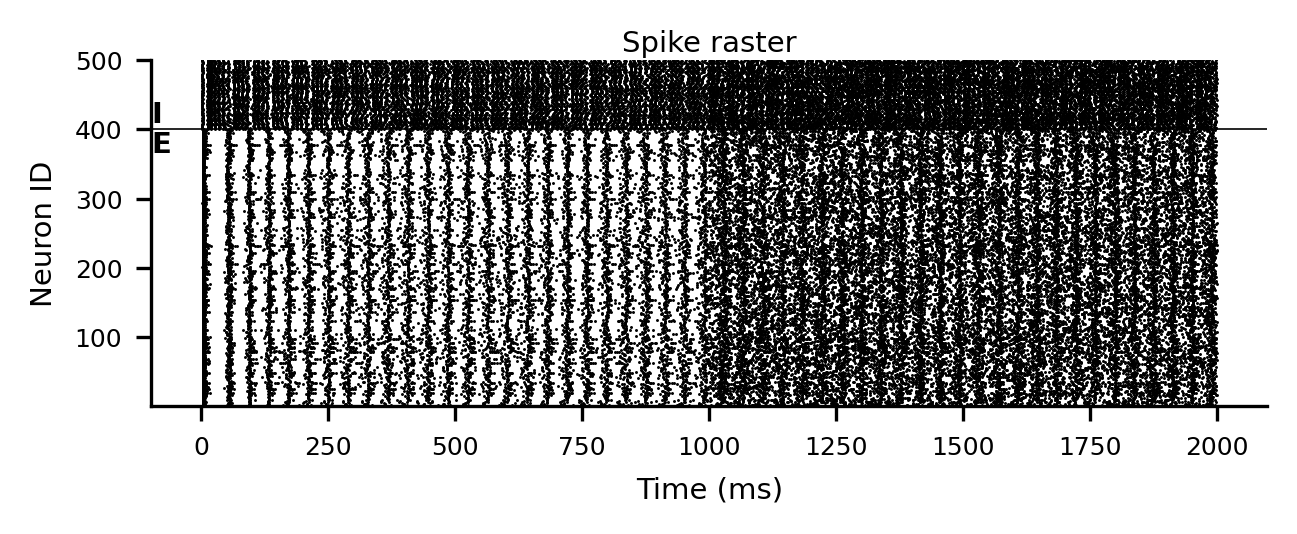

In [33]:
plot_raster(A_noisy, neurons, final_state.W, T_total=T)
plt.show()

In [36]:
n_entropies[3000:4000]

[]

In [60]:
array_test = A_noisy
den_H =  im.entropy(array_test[2000:4000], **im_args) - im.entropy(array_test[4000:6000] , **im_args)  # H(A) - H(B) -> Instant change
num_H =  im.entropy(array_test[6000:8000], **im_args) - im.entropy(array_test[4000:6000]  , **im_args) # H(C) - H(B) -> Late recovery

R_H =  num_H / den_H
R_H

np.float64(-0.0)

In [61]:
R_H

np.float64(-0.0)

In [43]:
im.entropy(A_noisy[2000:4000], **im_args)

np.float64(11.576100544419388)

In [44]:
im.entropy(A_noisy[4000:6000], **im_args) 

np.float64(11.686771131346347)

In [45]:
im.entropy(A_noisy[6000:8000], **im_args)

np.float64(11.686771131346347)

In [49]:
A_noisy.shape

(8000, 500)

In [8]:
# spike_entropy_rate_binned.py
import numpy as np
import infomeasure as im

# --- User parameters ---
spike_seq = [0,0,1,0,0,1,1,0,1,0,
             0,0,1,0,1,0,0,0,0,1,
             0,1,0,0,1,0,0,1,0,0,
             0,1,0,0,1,0,0,0,1,0]

dt_sim = 0.25    # simulation time step
dt_bin = 1.0     # bin size for entropy calculation (can be > dt_sim)

# --- Convert spike sequence to numpy array ---
x = np.array(spike_seq, dtype=int)

# --- Bin the spike train ---
bin_factor = int(dt_bin / dt_sim)
if bin_factor < 1:
    raise ValueError("dt_bin must be >= dt_sim")

# Number of bins after grouping
n_bins = len(x) // bin_factor
x_binned = x[:n_bins*bin_factor].reshape(n_bins, bin_factor)
# Use 1 if any spike occurs in the bin, 0 otherwise
x_binned = x_binned.max(axis=1)


In [9]:
x_binned

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:

print(f"Binned spike train (length {len(x_binned)}): {x_binned}")

# --- Compute binned entropy ---
H_bin_bits = im.entropy(x_binned, base=2)
H_rate_bits_per_time = H_bin_bits / dt_bin

print(f"Binned entropy per bin: {H_bin_bits:.4f} bits")
print(f"Entropy rate (bits per time unit): {H_rate_bits_per_time:.4f}")

# --- ISI-based entropy rate ---
spike_indices = np.where(x_binned == 1)[0]

if len(spike_indices) < 2:
    print("Not enough spikes for ISI-based estimate.")
else:
    isis_bins = np.diff(spike_indices)
    isis_time = isis_bins * dt_bin

    # Map unique ISIs to integers for discrete entropy
    unique_isis, codes = np.unique(isis_time, return_inverse=True)
    H_isi_bits = im.entropy(codes, base=2)
    mean_isi = isis_time.mean()
    H_rate_isi_bits_per_time = H_isi_bits / mean_isi

    print(f"Unique ISIs (time units): {unique_isis}")
    print(f"ISI entropy (bits): {H_isi_bits:.4f}")
    print(f"Mean ISI (time units): {mean_isi:.4f}")
    print(f"ISI-based entropy rate (bits per time unit): {H_rate_isi_bits_per_time:.4f}")